# Necassary Imports

In [10]:
# Imports
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import re
#import inflect
#from num2words import num2words
from nltk.corpus import stopwords
from collections import Counter

import sklearn

from gensim.models import Word2Vec

from sklearn.model_selection import ParameterSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV

from nltk.stem import WordNetLemmatizer
import nltk 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bvits\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bvits\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bvits\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Necassary preprocessing steps

In [7]:
# Import data
df = pd.read_csv('us_equities_news_dataset.csv')

In [8]:
# Filter out Nvidia articles
nvidia_df = df[df['title'].str.contains('NVIDIA|NVDA', case=False, na=False) |
               df['content'].str.contains('NVIDIA|NVDA', case=False, na=False) |
               df['ticker'].str.contains('NVIDIA|NVDA', case=False, na=False)]

In [9]:
print(len(nvidia_df))

3464


In [11]:
#Pre processing steps
def preprocess_text_iteration1(text):
    text = text.strip()
    # Replace URLs with an empty string
    re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    words = word_tokenize(text.lower())
    #check if the word is alpha numeric
    alpha_words = [word for word in words if word.isalpha()]
    #remove numbers
    numbers_words = [word for word in alpha_words if not word.isdigit()]
    return numbers_words

# apply preprocessing
nvidia_df['content'] = nvidia_df['content'].apply(preprocess_text_iteration1)

C:\Users\bvits\AppData\Local\Temp\ipykernel_17108\654137544.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvidia_df['content'] = nvidia_df['content'].apply(preprocess_text_iteration1)


In [14]:
#create a document term matrix
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(nvidia_df['content'].apply(lambda x: ' '.join(x)))
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


Topic 0: the to nasdaq at nyse on was inc and in
Topic 1: the to and of in that is on for it
Topic 2: the of and in to for on is as that
Topic 3: the of to and in zacks is year company for
Topic 4: the to and of in that is for with its
[[3.33679444e-04 9.98672051e-01 3.31530940e-04 3.32240994e-04
  3.30497360e-04]
 [1.46724347e-02 9.84048657e-01 4.24542898e-04 4.25398167e-04
  4.28967212e-04]
 [1.17503317e-01 1.57607207e-01 6.83934649e-01 4.47099975e-04
  4.05077274e-02]
 ...
 [3.06023673e-04 6.26508095e-02 6.73968436e-01 2.62765056e-01
  3.09674869e-04]
 [1.44314196e-04 3.58371492e-03 8.02585662e-01 1.93541172e-01
  1.45136982e-04]
 [2.46351826e-04 2.48833896e-04 6.22757718e-01 3.76499502e-01
  2.47594198e-04]]


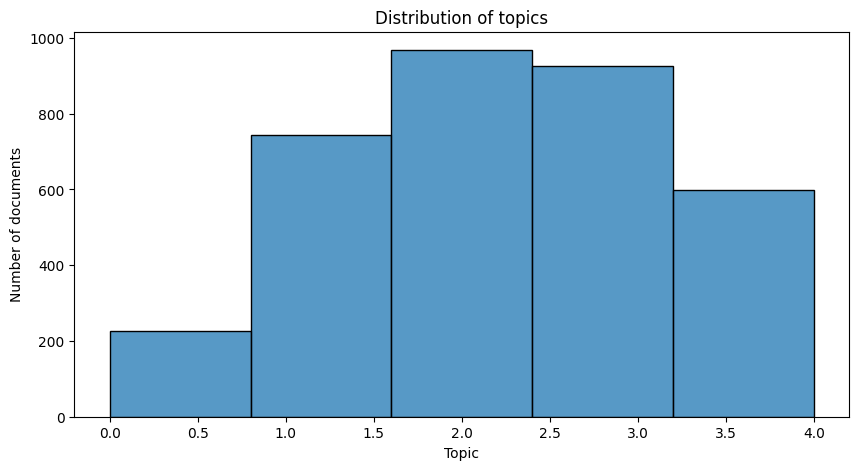

In [17]:
# train LDAModel
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(X)

# get topics
def get_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names_out()
    topics = []
    for topic in model.components_:
        topic_words = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(topic_words)
    return topics

topics = get_topics(lda, vectorizer, 10)
for i, topic in enumerate(topics):
    print('Topic {}: {}'.format(i, ' '.join(topic)))

# get topic distribution for each document
topic_dist = lda.transform(X)
print(topic_dist)

# plot the distribution of topics
plt.figure(figsize=(10, 5))
sns.histplot(topic_dist.argmax(axis=1), bins=5)
plt.xlabel('Topic')
plt.ylabel('Number of documents')
plt.title('Distribution of topics')
plt.show()



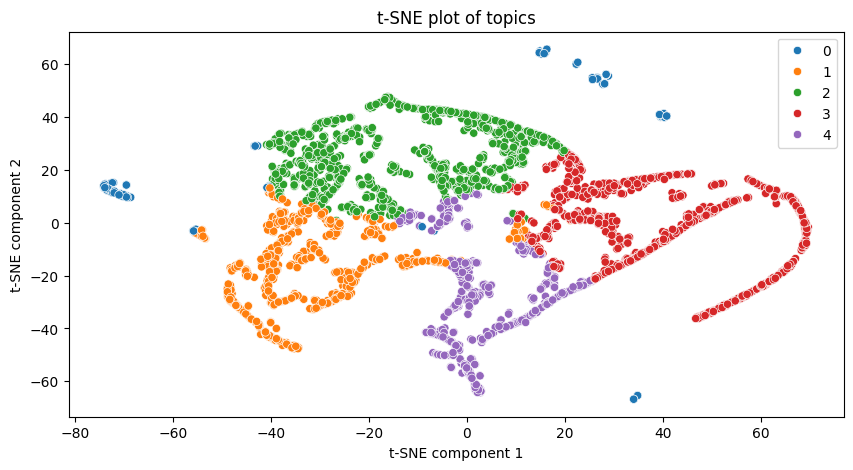

In [18]:
# create a cluster plot for the topics

#if we have more time we look this because it is a cool plot (we don't fully understand it because copilot made it)

# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, random_state=0)
# tsne_embedding = tsne.fit_transform(topic_dist)
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=tsne_embedding[:, 0], y=tsne_embedding[:, 1], hue=topic_dist.argmax(axis=1), palette='tab10')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# plt.title('t-SNE plot of topics')
# plt.show()